In [ ]:
'''
Hi Ioannis after the loop you will find the coeffs

You will have 10 Instances each solving 3 Walks (30 Datapoints)

'''

In [2]:
import os 
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pdb
from pyarrow import feather
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import ptitprince as pt


# figure defaults
plt.rcParams.update({'font.size': 20})
plt.rcParams["figure.figsize"] = (7, 7)
plt.rcParams['axes.grid'] = True

In [3]:
#move up in directory
os.chdir('../')

from helpers import dot2_

In [4]:
os.getcwd()

'C:\\Users\\Bio_Psych\\Desktop\\Deniz\\tf-cpu\\p1_generalization'

In [5]:
# CONFIG

PATH_RNN_DATA ='data/rnn_raw_data/'
RNN_FILE_NAME = 'lstm2_a2c_nh_48_lr_0_0001_n_u_p_0_5_ew_0_vw_0_5_dr_0_5_res_d_f_p_0_1_rt_con_a_4_n_300_te_50000_id_{}_test_b_daw_p_{}'

# number of RNN instances
N_IDS = 10
# number of random walk instances
N_WALKS = 3
# number of trials per episode
N_TRIALS = 300
# number of actions/bandits
N_ACTIONS = 4

# Stay vs Switch Choice predictions (PCA)

In [10]:
rnn_file_path = PATH_RNN_DATA + RNN_FILE_NAME

# collect a boolean for switch trials
is_switch = np.zeros([N_IDS*N_WALKS,N_TRIALS])
# collect choice predictions
choice_preds = np.zeros([N_IDS*N_WALKS,N_TRIALS])
# container for choices for all RNN instances
all_choices = np.zeros([N_IDS*N_WALKS,N_TRIALS])
# container for correct choice predictions (1 == correct prediction)
accuracy = np.zeros([N_IDS*N_WALKS,N_TRIALS])
# container for mean correct choice predictions in switch trials
switch_accuracy = np.zeros([N_IDS*N_WALKS])
# container for mean correct choice predictions in stay trials
stay_accuracy = np.zeros([N_IDS*N_WALKS])
# collect coefficients of the regression (48 hidden units/pcs)
coeffs = np.zeros([N_IDS*N_WALKS, N_ACTIONS, 48])

# loop over walks and instances (id_)
for walk in range(1, N_WALKS+1):
     for id_ in range(N_IDS):


        # get data from RNN instance
        d = pickle.load(open(rnn_file_path.format(id_, walk), 'rb'))
        df = d.reset_index()
        # get choices
        choices = df.choice.to_numpy()
        # extract hidden unit activity
        hidden_units = df.loc[:, [col.startswith('rnn_state') for col in df.columns.values]]
        # init pca object
        pca = PCA()
        # standardize hidden unit activity
        st_hidden = StandardScaler().fit_transform(hidden_units)  
        # predictor X is principal components of standardized hidden units
        X = pca.fit_transform(st_hidden)

        ##################################################
        # choice predictions with multinomial regression 
        ##################################################

        # get observed choices
        y = np.array(df.choice)
        # fit multinomial model
        model = LogisticRegression(multi_class='multinomial', solver = 'lbfgs', max_iter=500).fit(X,y)
        # save choice predictions for all actions
        choice_preds[(walk-1)*N_IDS+id_,:] = model.predict(X)
        # collect coefficients
        coeffs[(walk-1)*N_IDS+id_,:,:] = model.coef_

        #########################
        # variable collection 
        #########################

        # get switch trials 
        is_switch[(walk-1)*N_IDS+id_, :] = df.is_switch.to_numpy()

        # get choices
        all_choices[(walk-1)*N_IDS+id_, :] = choices

        # get accuracy (1 == accurate prediction)
        accuracy[(walk-1)*N_IDS+id_, :] = choices == model.predict(X)
        
        # get switch accuracy (n_correct_predictions for switch trials / n_switches)
        switch_accuracy[(walk-1)*N_IDS+id_] = np.mean((choices == model.predict(X))[df.is_switch.to_numpy()==1])
        
        # get stay accuracy (n_correct_predictions for stay trials / n_stay)
        stay_accuracy[(walk-1)*N_IDS+id_] = np.mean((choices == model.predict(X))[df.is_switch.to_numpy()==0])

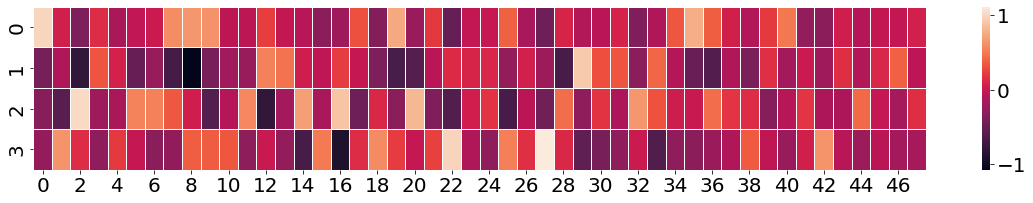

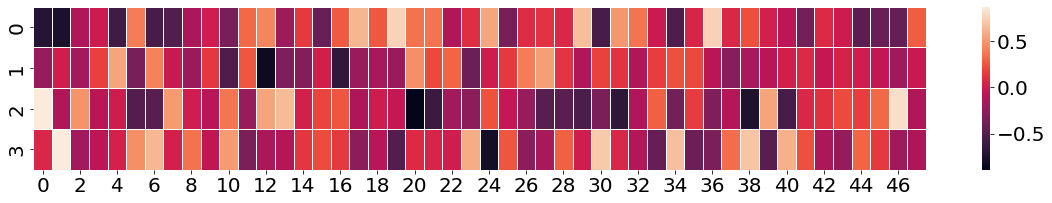

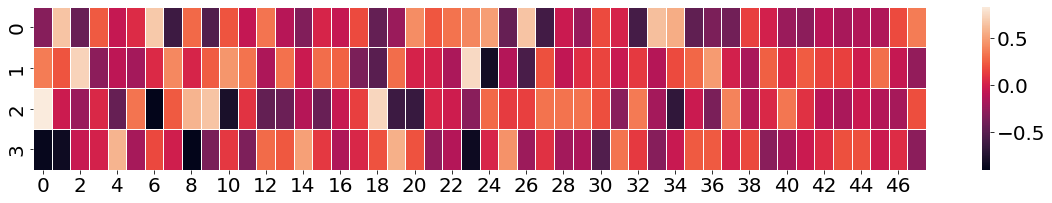

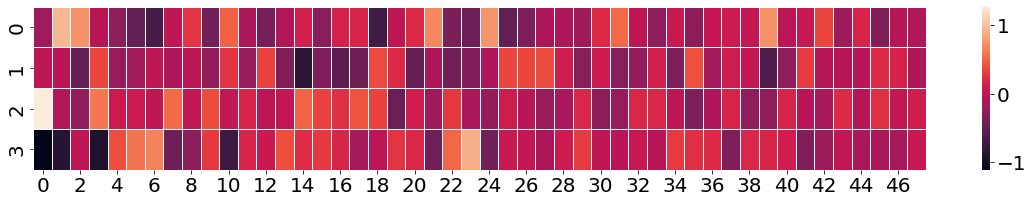

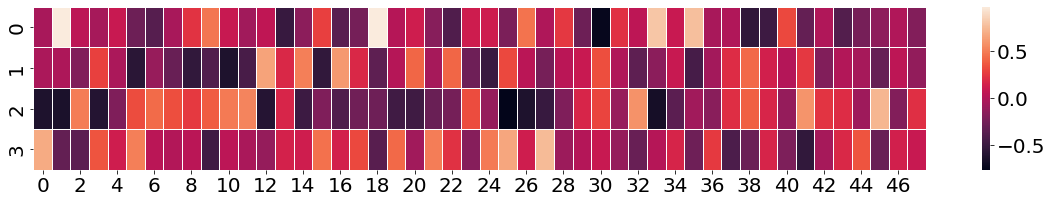

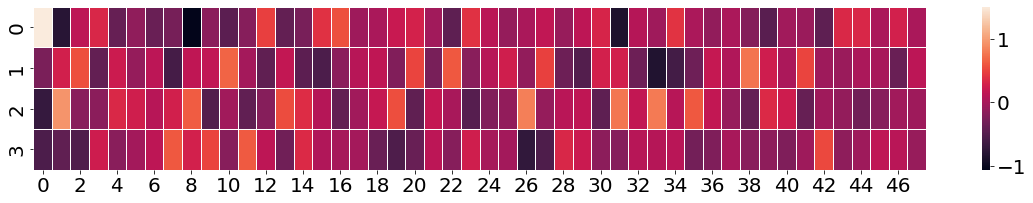

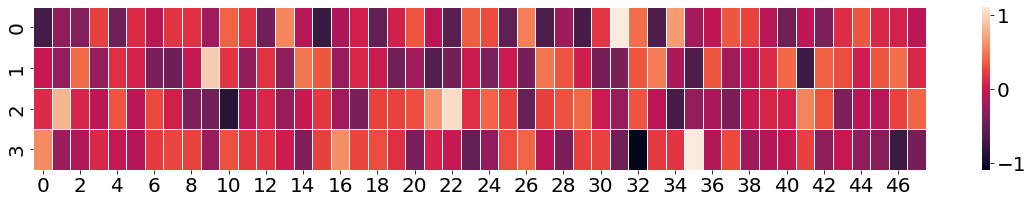

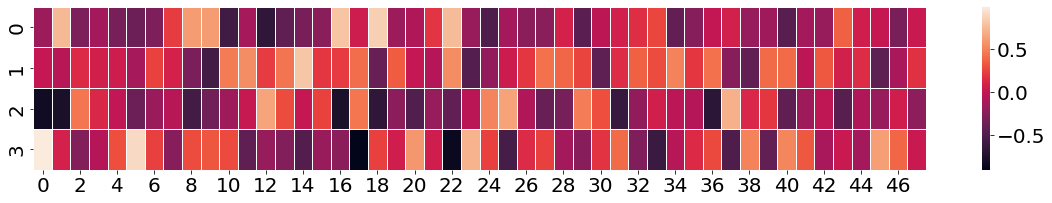

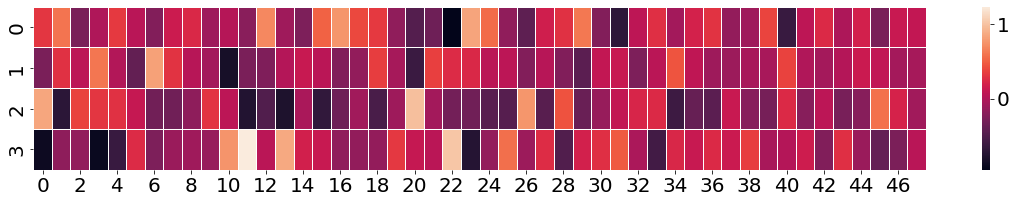

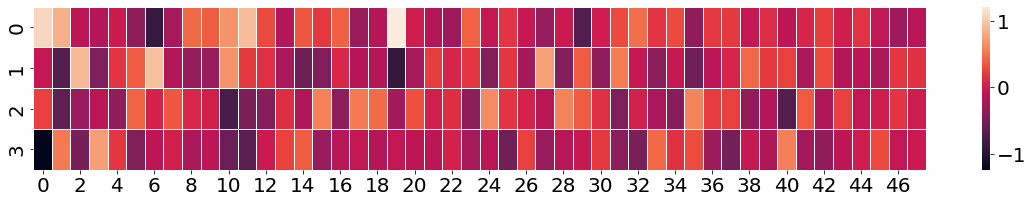

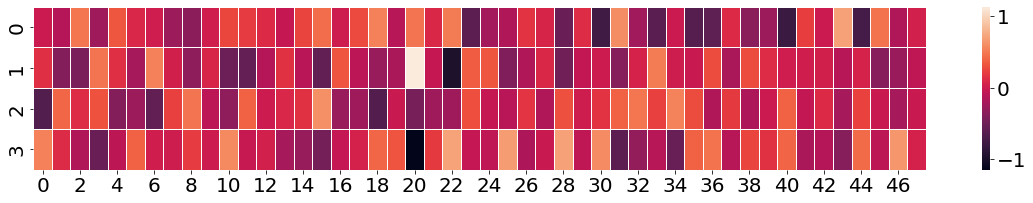

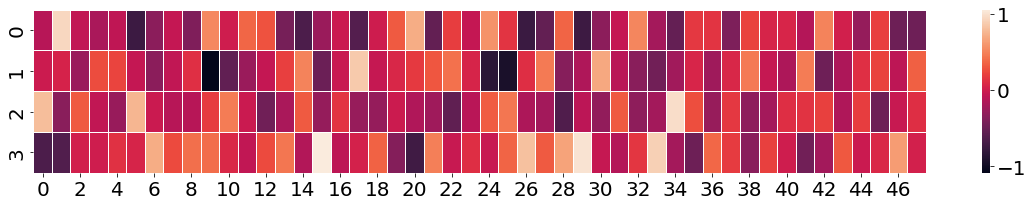

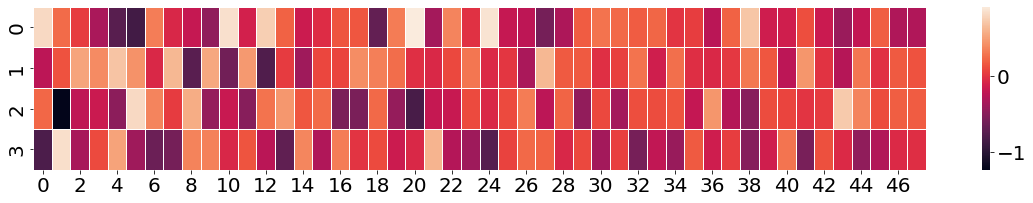

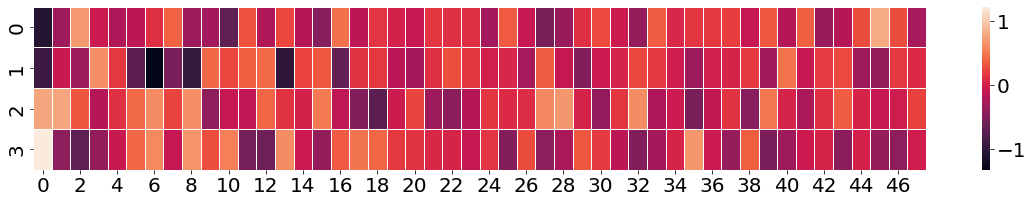

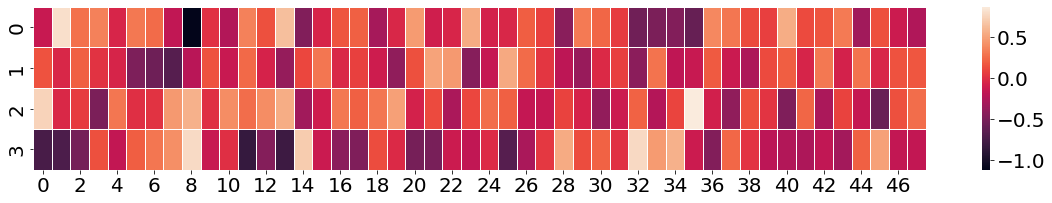

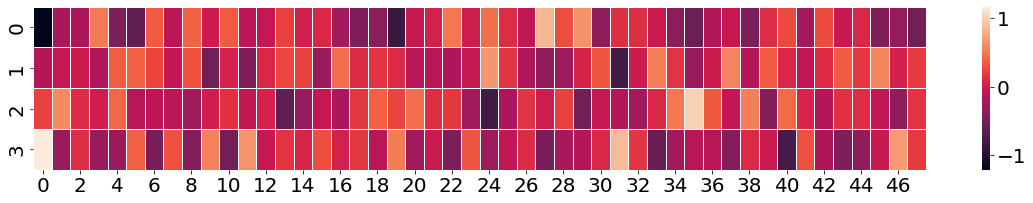

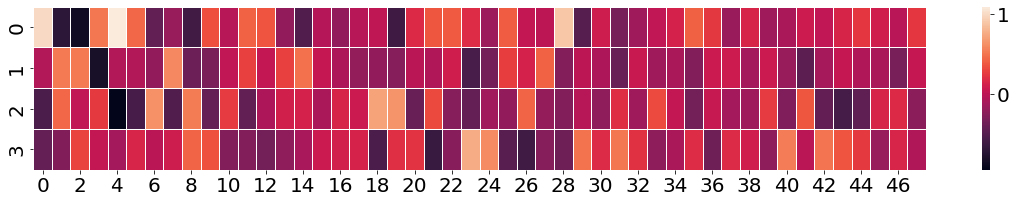

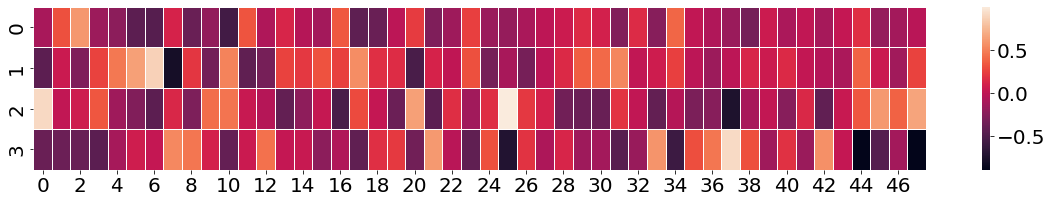

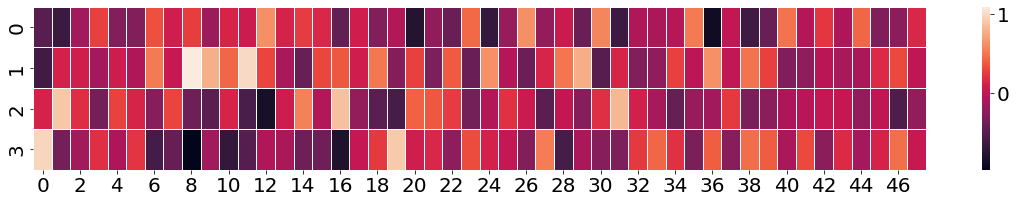

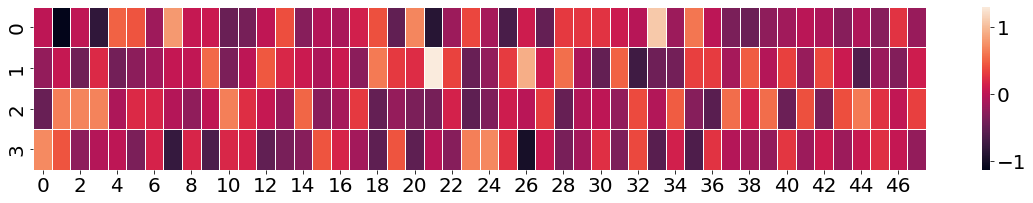

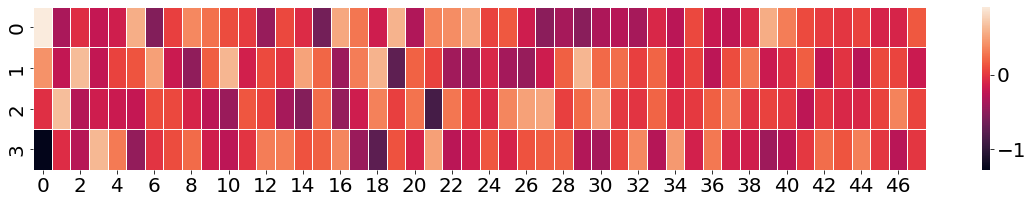

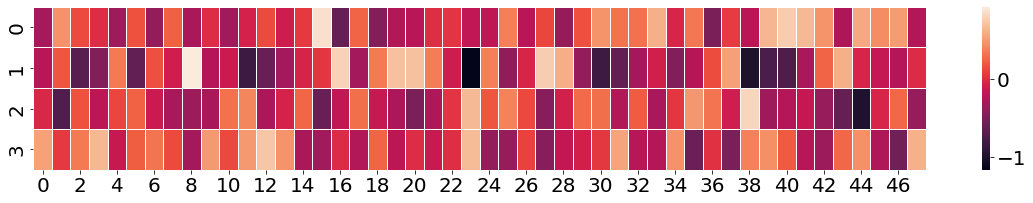

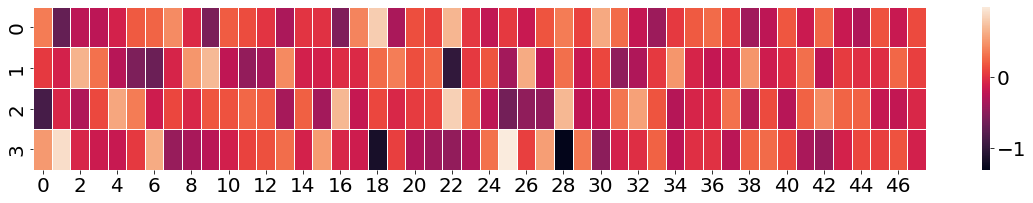

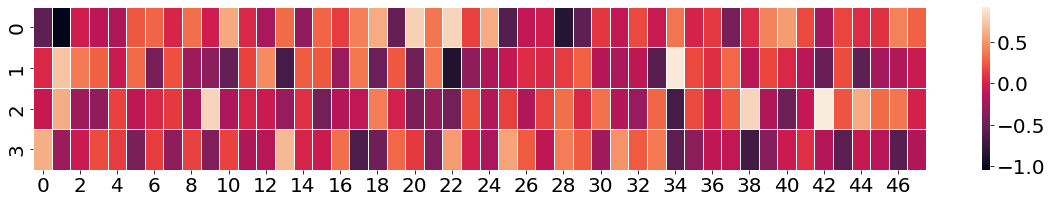

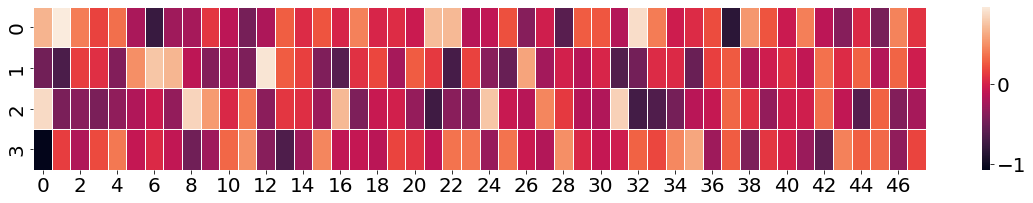

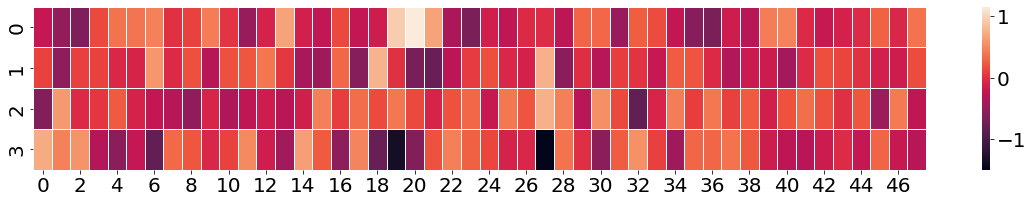

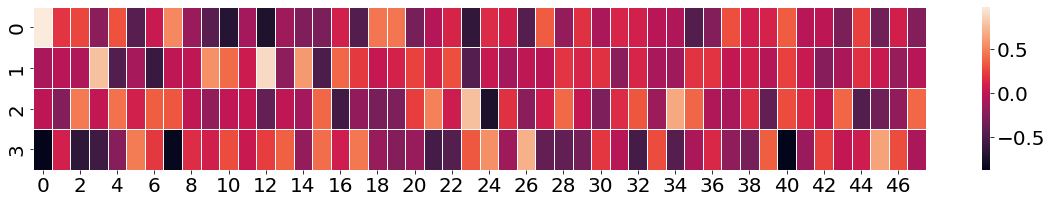

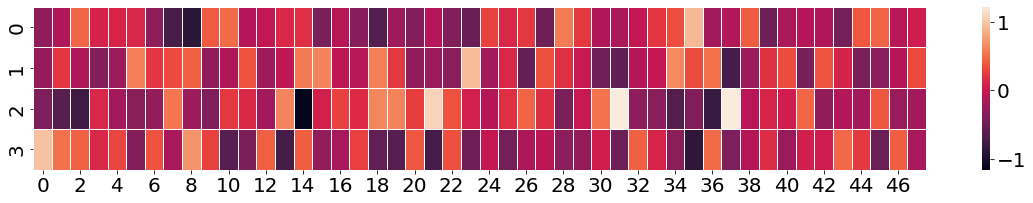

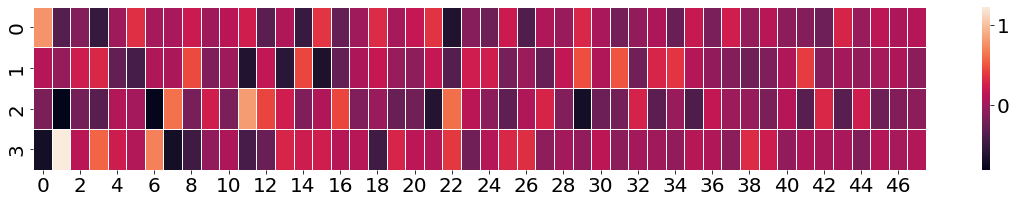

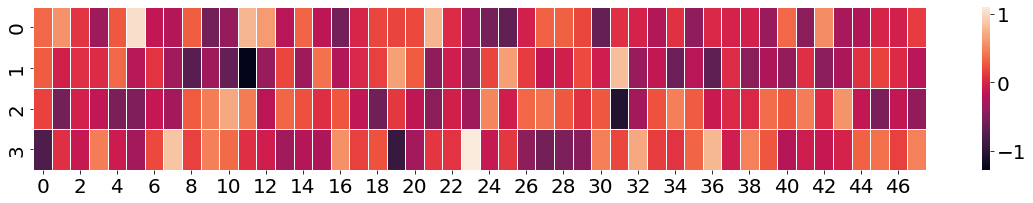

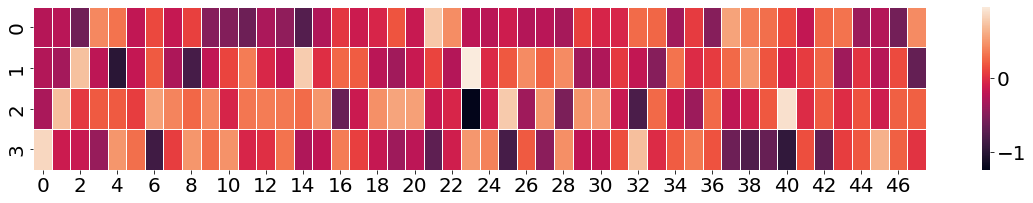

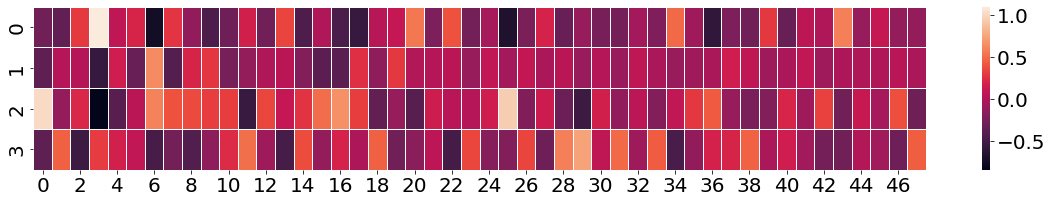

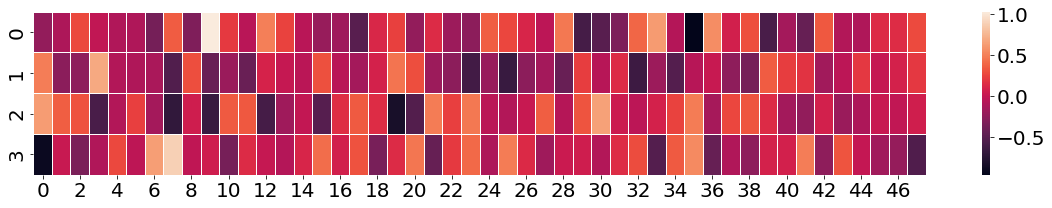

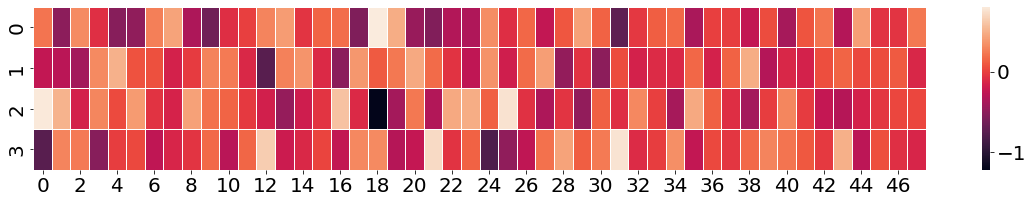

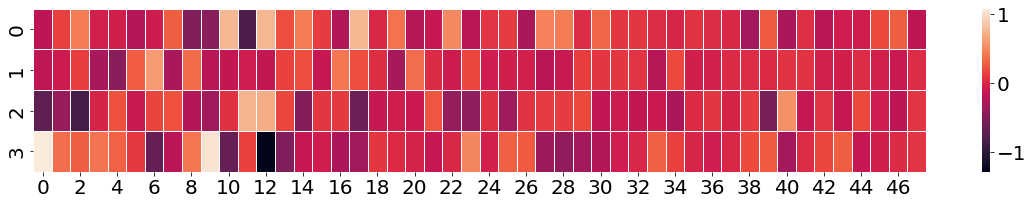

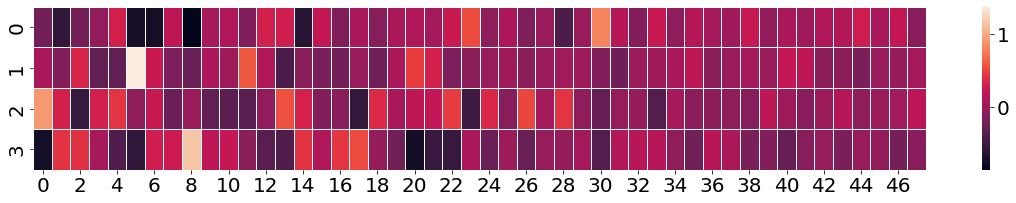

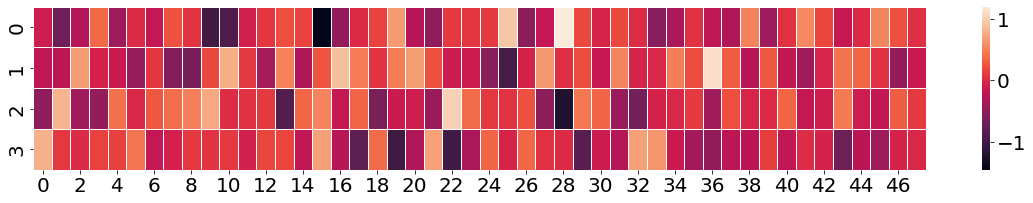

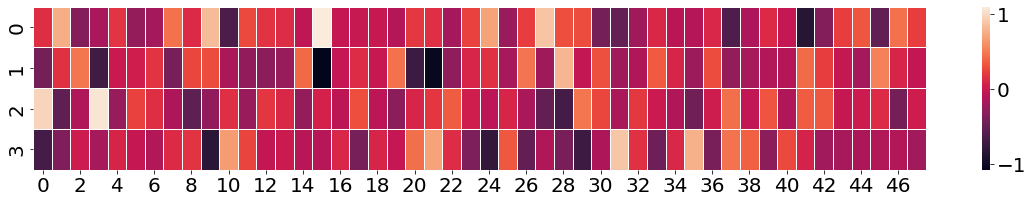

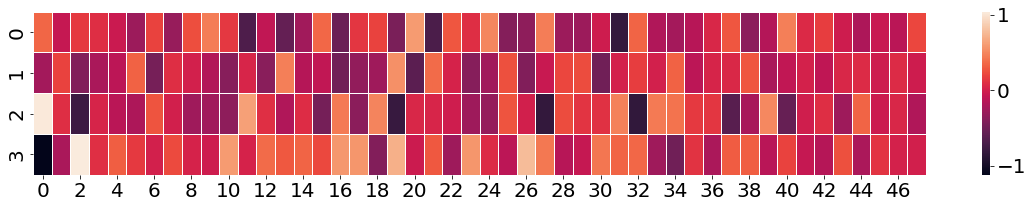

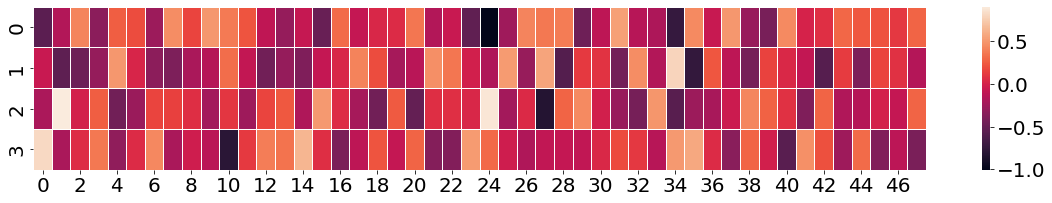

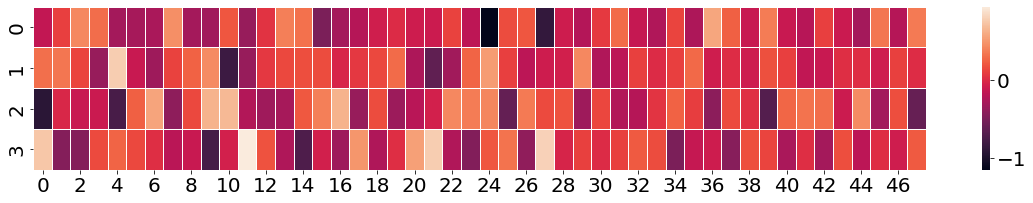

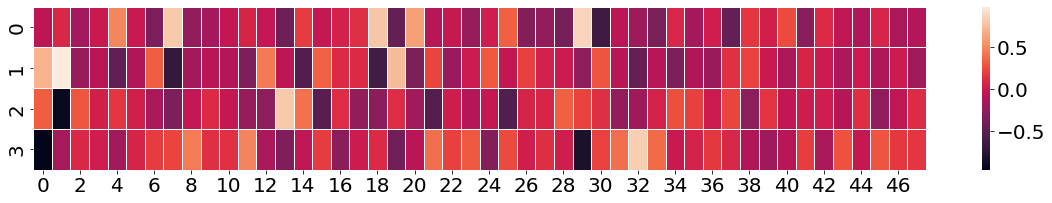

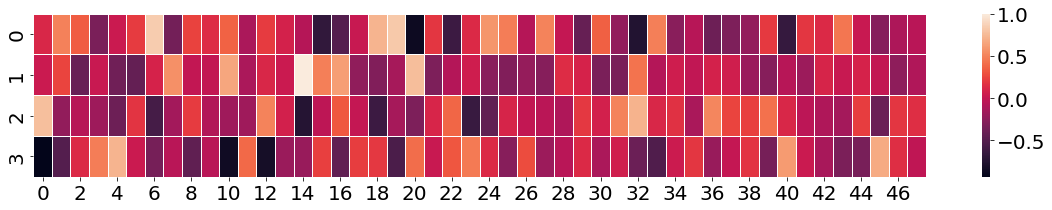

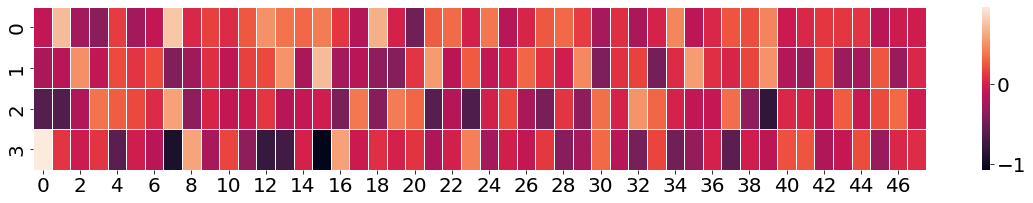

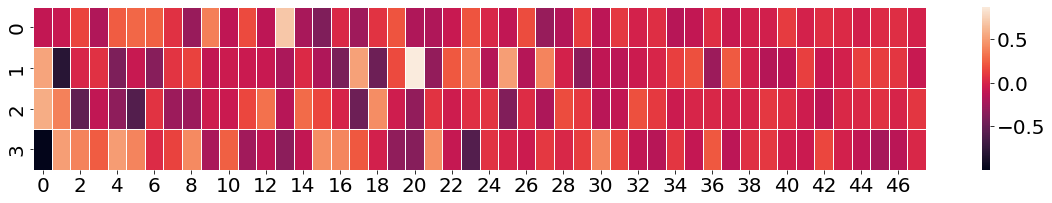

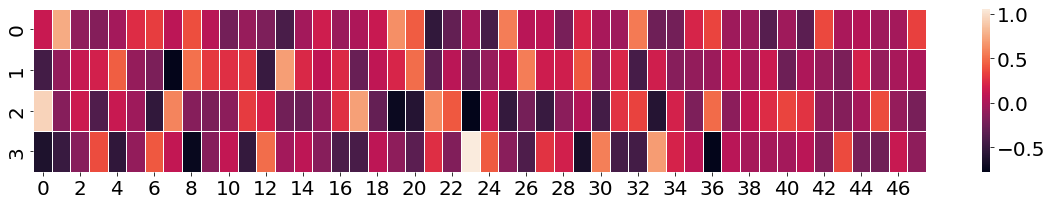

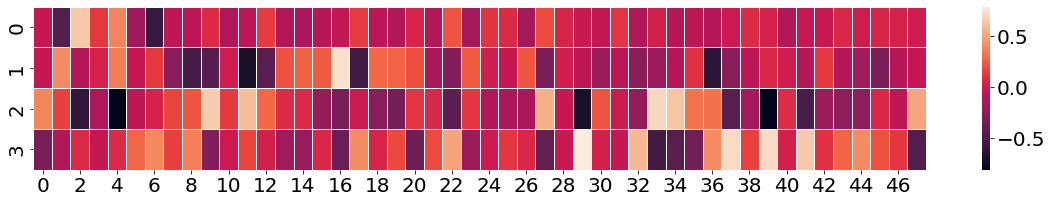

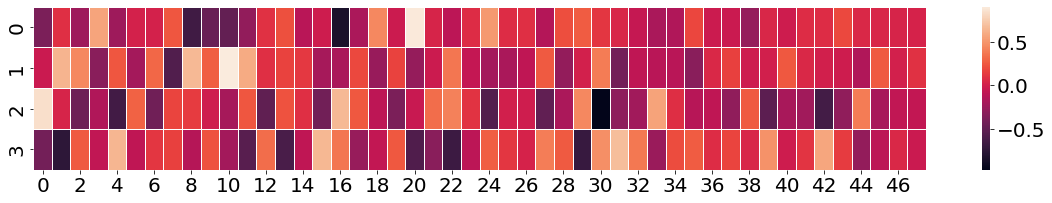

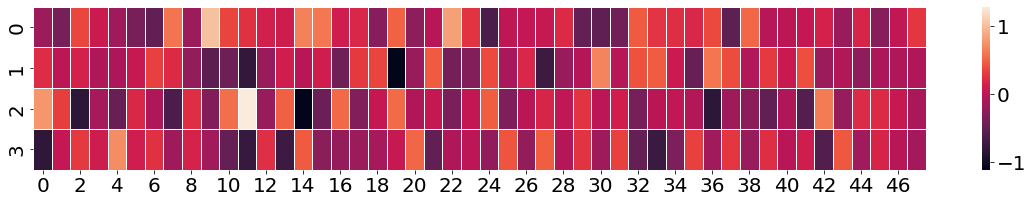

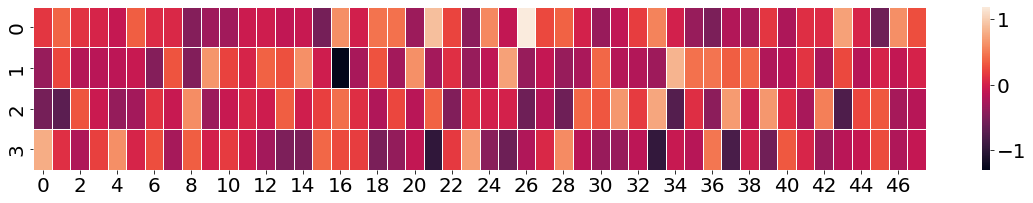

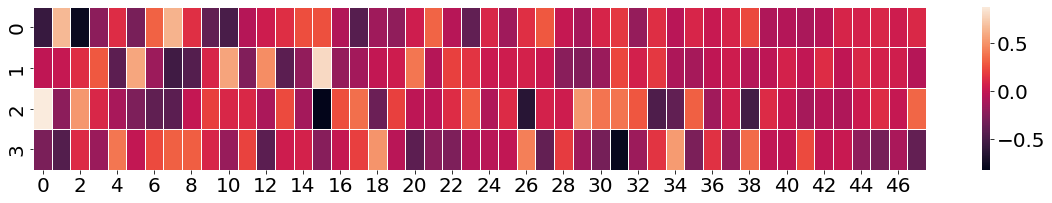

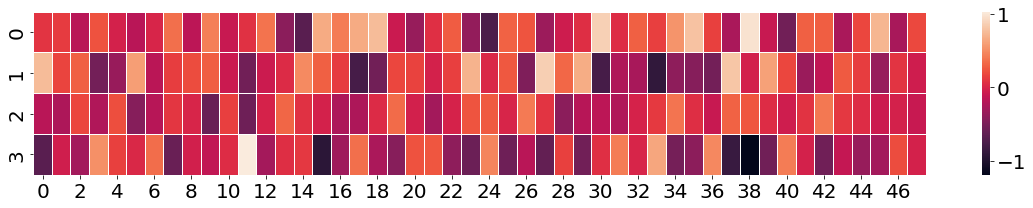

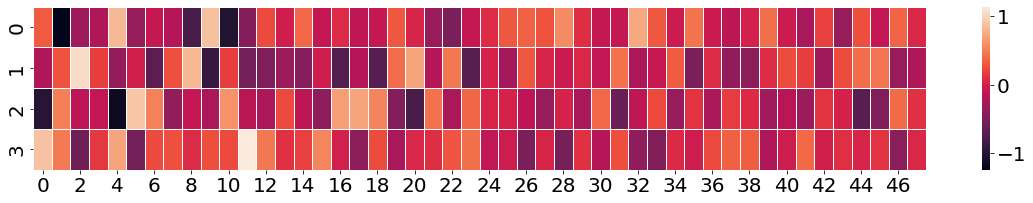

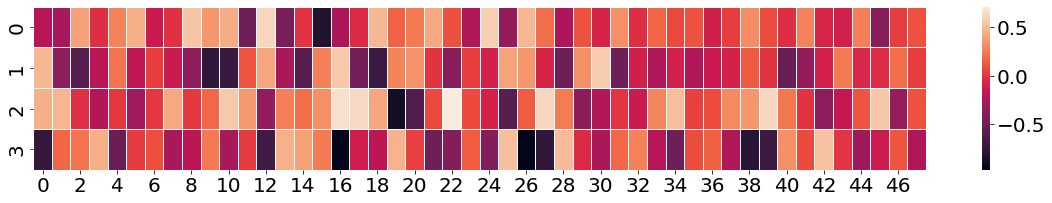

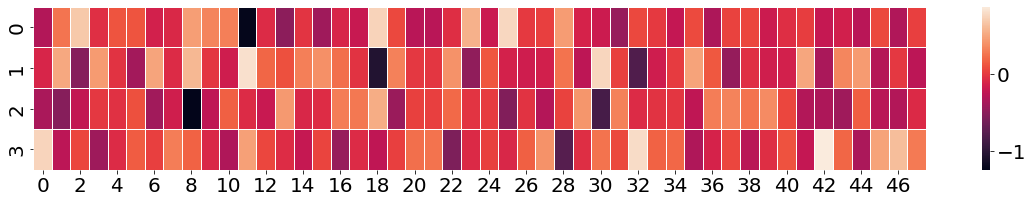

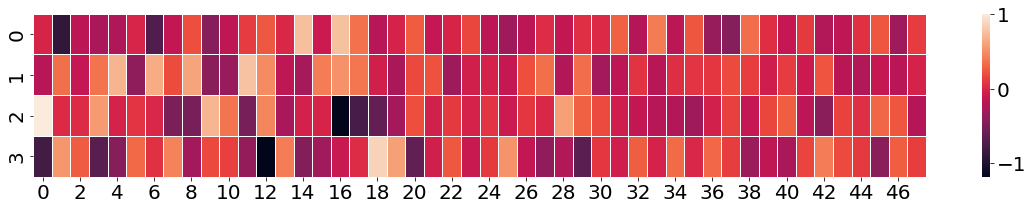

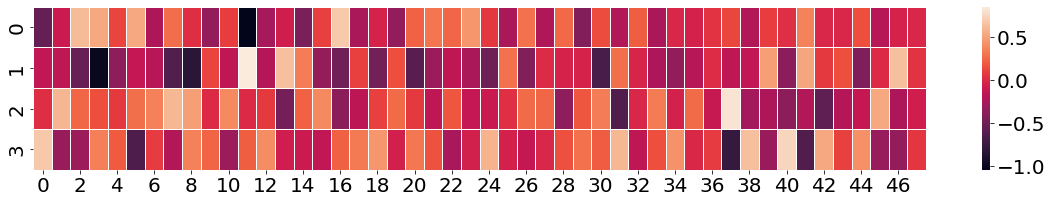

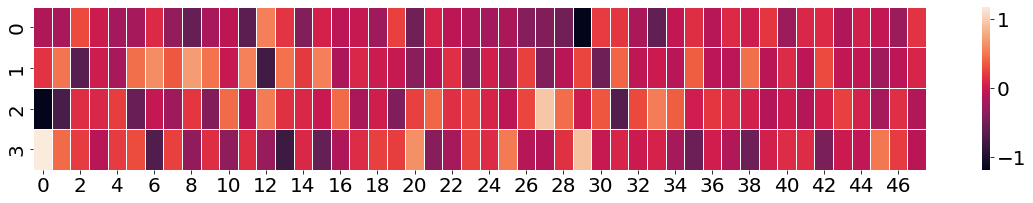

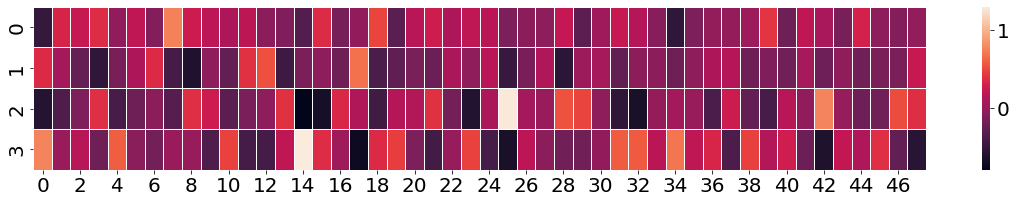

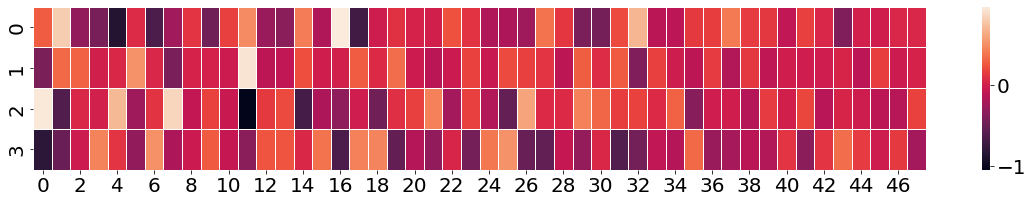

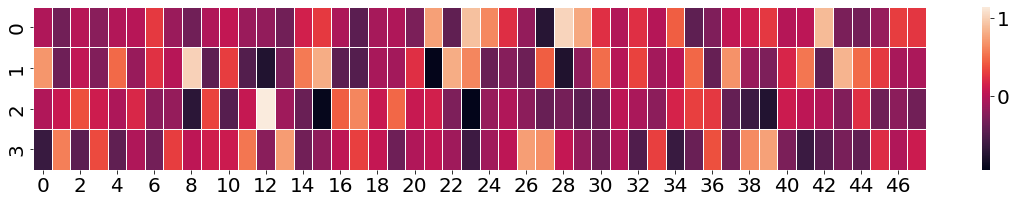

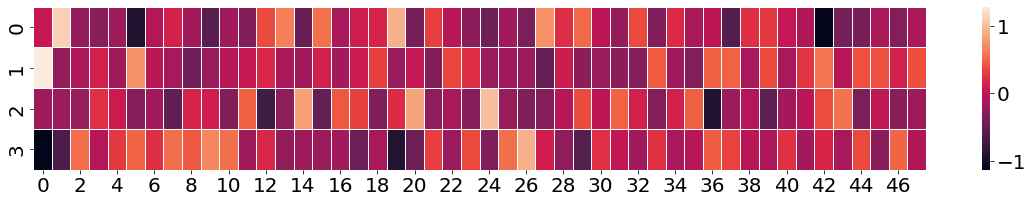

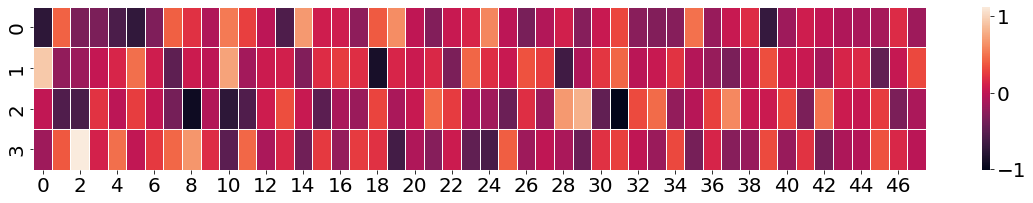

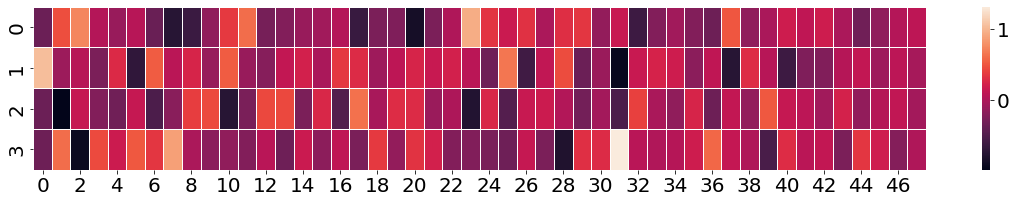

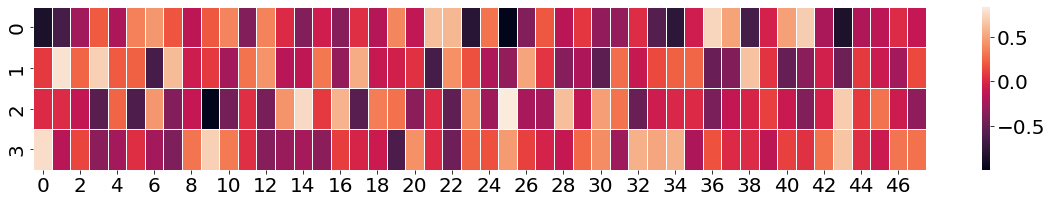

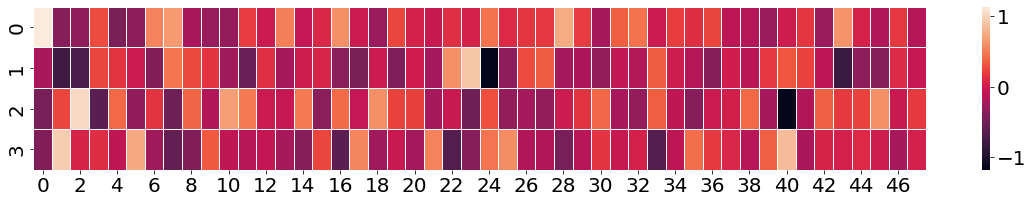

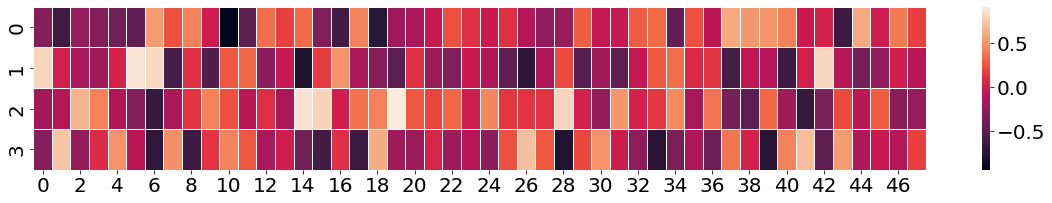

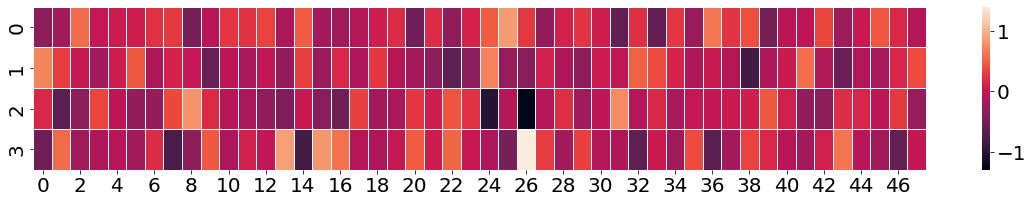

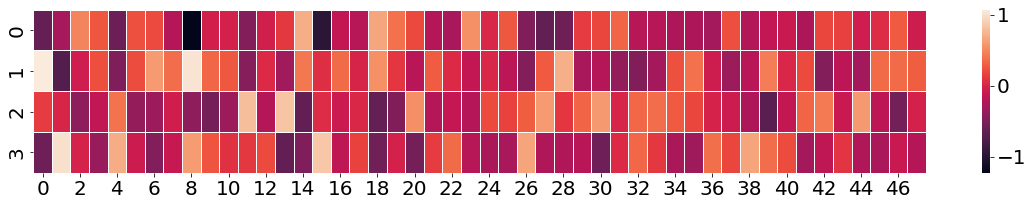

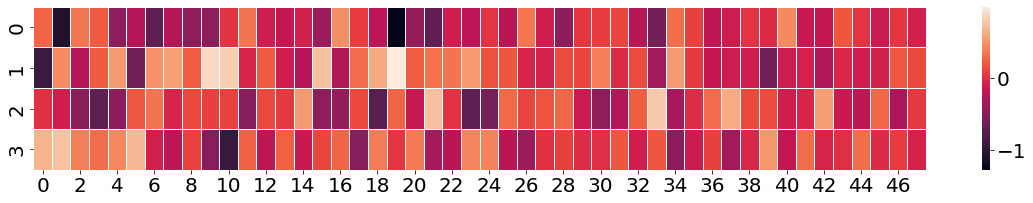

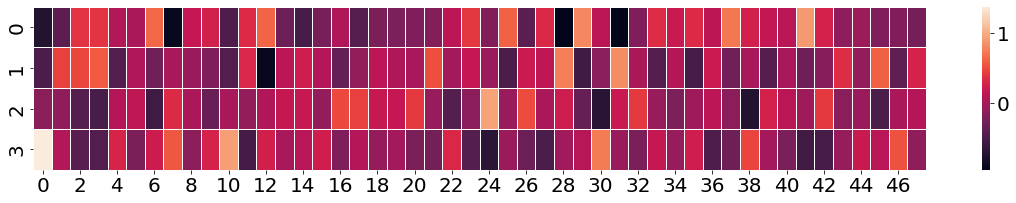

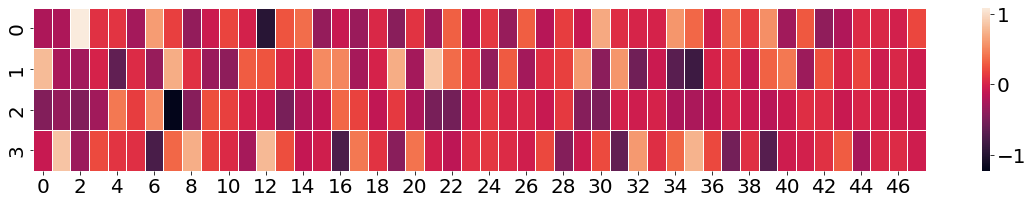

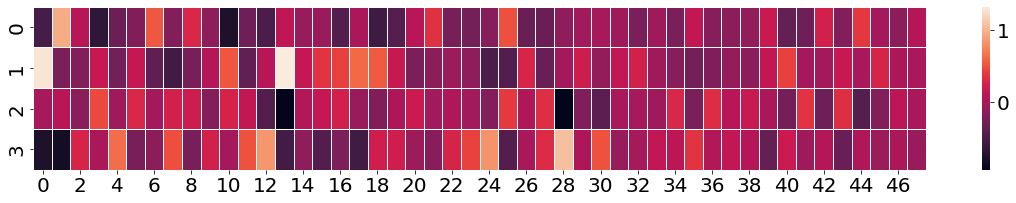

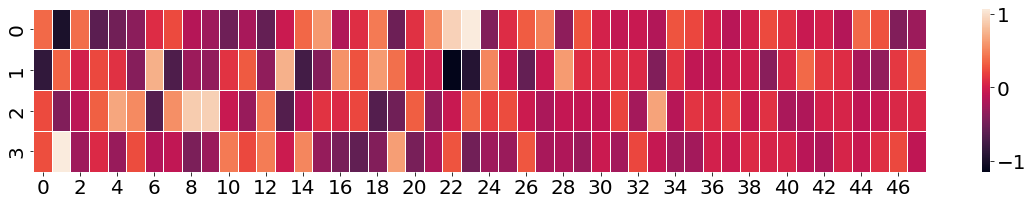

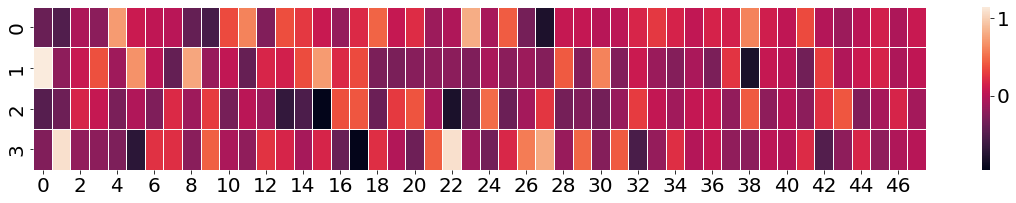

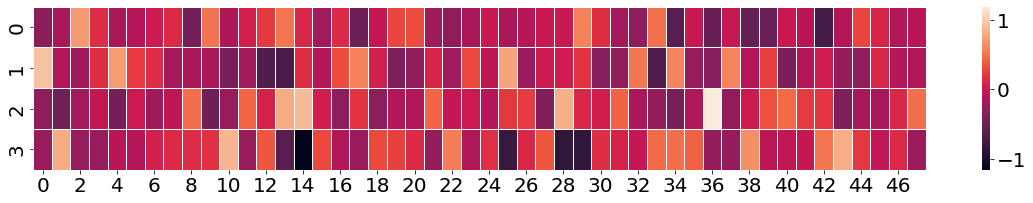

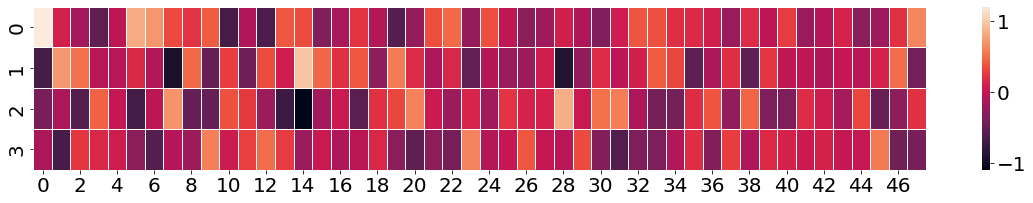

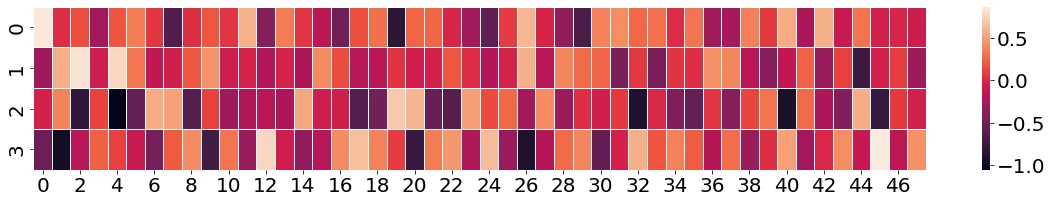

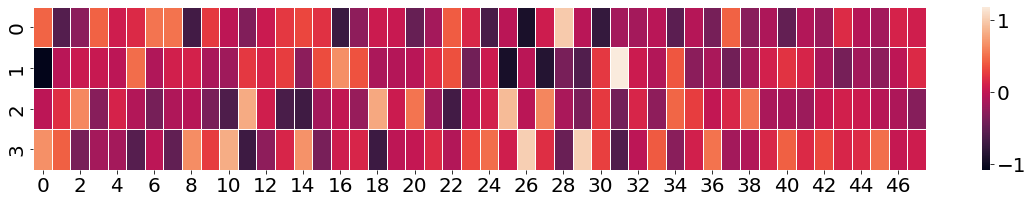

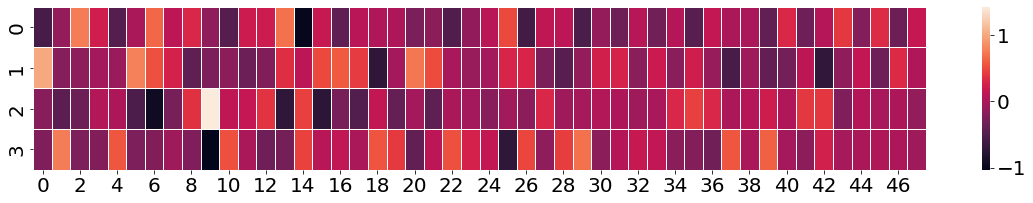

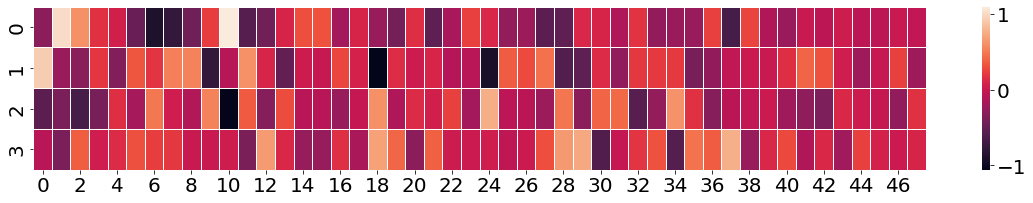

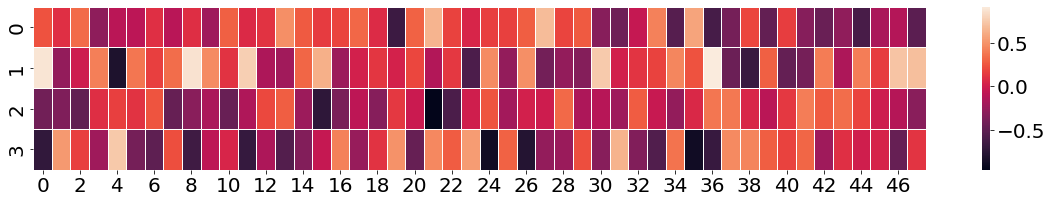

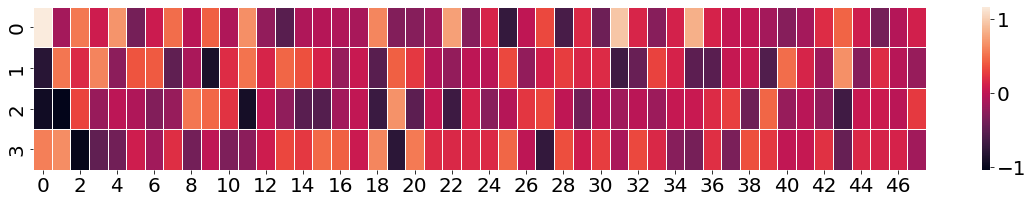

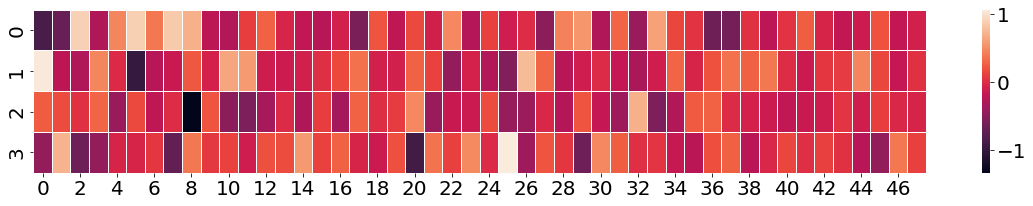

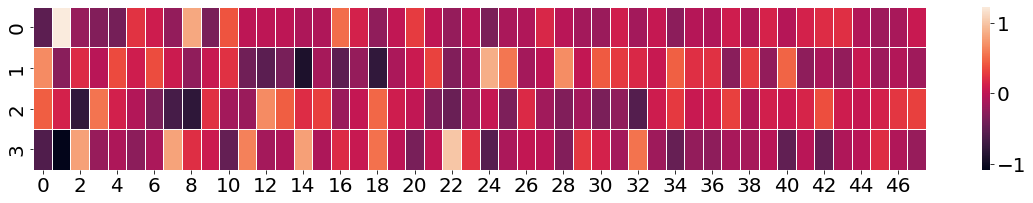

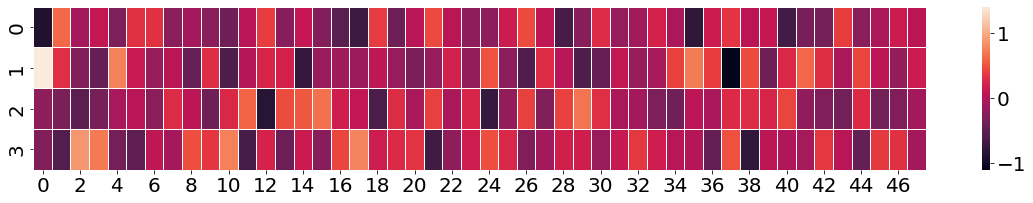

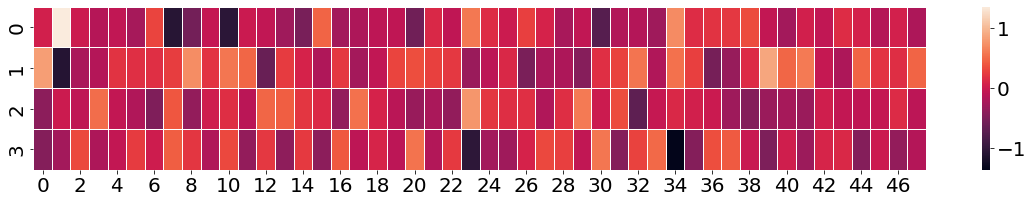

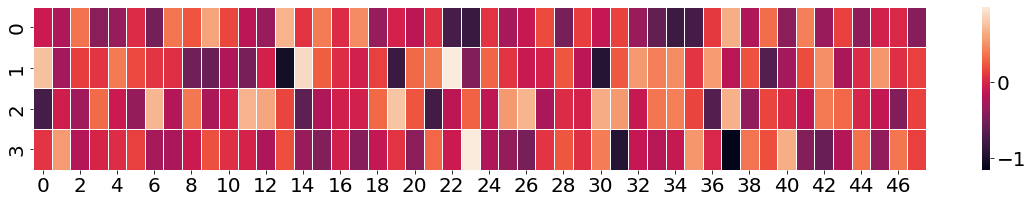

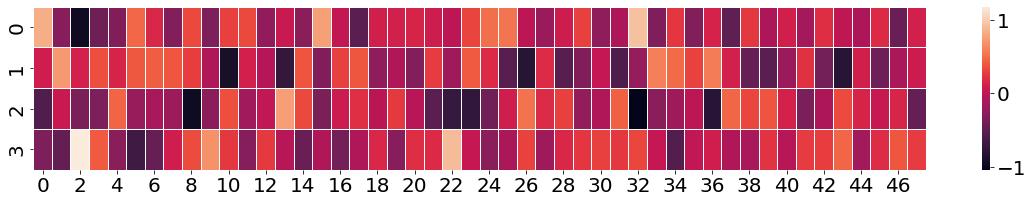

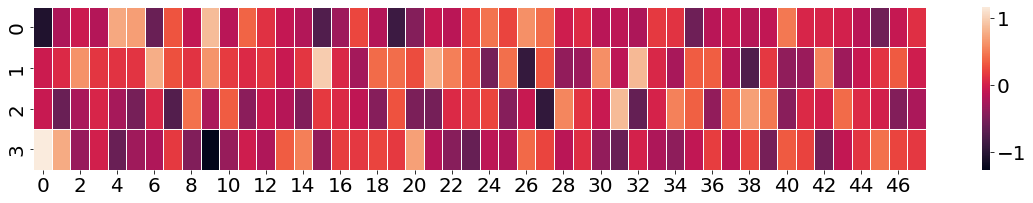

In [28]:
'''
Hi Ioannis

you can inspect the coeffs like this [x-axis: PCs, y-axis: 4 actions, head is coefficient value]

'''
plt.rcParams["figure.figsize"] = (20, 3)


for data_point in range(np.shape(coeffs)[0]):
    ax = sns.heatmap(coeffs[data_point,:, :], linewidth=0.5)
    plt.show()


# Stay/Switch Accuracy

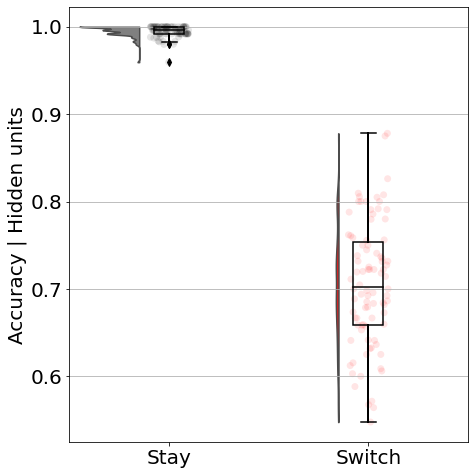

In [9]:
# create plot df
plot_df = pd.DataFrame({"accuracy": list(stay_accuracy) + list(switch_accuracy),
                       "type": ['Stay'] * len(stay_accuracy)  + ['Switch'] * len(switch_accuracy)
                       })

# half violin plots
f, ax = plt.subplots()
dy="accuracy"; dx="type"; ort="v"; pal = {"Stay": "grey", "Switch": "red"}

ax=pt.half_violinplot( x = dx, y = dy, data = plot_df, palette = pal, bw = .2, cut = 0.,
                      scale = "area", width = .6, inner = None, orient = ort)


pal1 = {"Stay": "black", "Switch": "red"}
ax=sns.stripplot( x = dx, y = dy, data = plot_df, palette = pal1, edgecolor = "white",
size = 7, jitter = 1, zorder = 0, orient = ort, alpha = 0.1)

x=sns.boxplot( x = dx, y = dy, data = plot_df, color = "black", width = .15, zorder = 10,\
showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
showfliers=True, whiskerprops = {'linewidth':2, "zorder":10},\
saturation = 1, orient = ort)

plt.ylabel('Accuracy | Hidden units')
plt.xlabel('')

plt.tight_layout()

# plt.savefig('../p1_generalization/plots/fig_5_F.png', dpi = 600)